#  Standard Hypo Test Inv Demo
Standard tutorial macro for performing an inverted  hypothesis test for computing an interval

This macro will perform a scan of the p-values for computing the interval or limit

Usage:

```cpp
root>.L StandardHypoTestInvDemo.C
root> StandardHypoTestInvDemo("fileName","workspace name","S+B modelconfig name","B model name","data set
name",calculator type, test statistic type, use CLS,
                               number of points, xmin, xmax, number of toys, use number counting)

type = 0 Freq calculator
type = 1 Hybrid calculator
type = 2 Asymptotic calculator
type = 3 Asymptotic calculator using nominal Asimov data sets (not using fitted parameter values but nominal ones)

testStatType = 0 LEP
             = 1 Tevatron
             = 2 Profile Likelihood two sided
             = 3 Profile Likelihood one sided (i.e. = 0 if mu < mu_hat)
             = 4 Profile Likelihood signed ( pll = -pll if mu < mu_hat)
             = 5 Max Likelihood Estimate as test statistic
             = 6 Number of observed event as test statistic
```




**Author:** Lorenzo Moneta  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:30 AM.</small></i>

In [1]:
%%cpp -d
#include "TFile.h"
#include "RooWorkspace.h"
#include "RooAbsPdf.h"
#include "RooRealVar.h"
#include "RooDataSet.h"
#include "RooStats/ModelConfig.h"
#include "RooRandom.h"
#include "TGraphErrors.h"
#include "TGraphAsymmErrors.h"
#include "TCanvas.h"
#include "TLine.h"
#include "TROOT.h"
#include "TSystem.h"

#include "RooStats/AsymptoticCalculator.h"
#include "RooStats/HybridCalculator.h"
#include "RooStats/FrequentistCalculator.h"
#include "RooStats/ToyMCSampler.h"
#include "RooStats/HypoTestPlot.h"

#include "RooStats/NumEventsTestStat.h"
#include "RooStats/ProfileLikelihoodTestStat.h"
#include "RooStats/SimpleLikelihoodRatioTestStat.h"
#include "RooStats/RatioOfProfiledLikelihoodsTestStat.h"
#include "RooStats/MaxLikelihoodEstimateTestStat.h"
#include "RooStats/NumEventsTestStat.h"

#include "RooStats/HypoTestInverter.h"
#include "RooStats/HypoTestInverterResult.h"
#include "RooStats/HypoTestInverterPlot.h"

#include <cassert>

In [2]:
%%cpp -d
// This is a workaround to make sure the namespace is used inside functions
using namespace RooFit;
using namespace RooStats;

In [3]:
using namespace std;

Structure defining the options

In [4]:
struct HypoTestInvOptions {

   bool plotHypoTestResult = true; // plot test statistic result at each point
   bool writeResult = true;        // write HypoTestInverterResult in a file
   TString resultFileName; // file with results (by default is built automatically using the workspace input file name)
   bool optimize = true;   // optimize evaluation of test statistic
   bool useVectorStore = true;  // convert data to use new roofit data store
   bool generateBinned = false; // generate binned data sets
   bool noSystematics = false;  // force all systematics to be off (i.e. set all nuisance parameters as constat
                                // to their nominal values)
   double nToysRatio = 2;       // ratio Ntoys S+b/ntoysB
   double maxPOI = -1;          // max value used of POI (in case of auto scan)
   bool useProof = false;       // use Proof Lite when using toys (for freq or hybrid)
   int nworkers = 0;            // number of worker for ProofLite (default use all available cores)
   bool enableDetailedOutput =
      false; // enable detailed output with all fit information for each toys (output will be written in result file)
   bool rebuild = false;       // re-do extra toys for computing expected limits and rebuild test stat
                               // distributions (N.B this requires much more CPU (factor is equivalent to nToyToRebuild)
   int nToyToRebuild = 100;    // number of toys used to rebuild
   int rebuildParamValues = 0; // = 0   do a profile of all the parameters on the B (alt snapshot) before performing a
                               // rebuild operation (default)
                               // = 1   use initial workspace parameters with B snapshot values
                               // = 2   use all initial workspace parameters with B
                               // Otherwise the rebuild will be performed using
   int initialFit = -1;        // do a first  fit to the model (-1 : default, 0 skip fit, 1 do always fit)
   int randomSeed = -1;        // random seed (if = -1: use default value, if = 0 always random )
                               // NOTE: Proof uses automatically a random seed

   int nAsimovBins = 0; // number of bins in observables used for Asimov data sets (0 is the default and it is given by
                        // workspace, typically is 100)

   bool reuseAltToys = false; // reuse same toys for alternate hypothesis (if set one gets more stable bands)
   double confLevel = 0.95;   // confidence level value

   std::string minimizerType =
      ""; // minimizer type (default is what is in ROOT::Math::MinimizerOptions::DefaultMinimizerType()
   std::string massValue = ""; // extra string to tag output file of result
   int printLevel = 0;         // print level for debugging PL test statistics and calculators

   bool useNLLOffset = false; // use NLL offset when fitting (this increase stability of fits)
};

HypoTestInvOptions optHTInv;

Internal class to run the inverter and more

In [5]:
namespace RooStats {

class HypoTestInvTool {

public:
   HypoTestInvTool();
   ~HypoTestInvTool(){};

   HypoTestInverterResult *RunInverter(RooWorkspace *w, const char *modelSBName, const char *modelBName,
                                       const char *dataName, int type, int testStatType, bool useCLs, int npoints,
                                       double poimin, double poimax, int ntoys, bool useNumberCounting = false,
                                       const char *nuisPriorName = 0);

   void AnalyzeResult(HypoTestInverterResult *r, int calculatorType, int testStatType, bool useCLs, int npoints,
                      const char *fileNameBase = 0);

   void SetParameter(const char *name, const char *value);
   void SetParameter(const char *name, bool value);
   void SetParameter(const char *name, int value);
   void SetParameter(const char *name, double value);

private:
   bool mPlotHypoTestResult;
   bool mWriteResult;
   bool mOptimize;
   bool mUseVectorStore;
   bool mGenerateBinned;
   bool mUseProof;
   bool mRebuild;
   bool mReuseAltToys;
   bool mEnableDetOutput;
   int mNWorkers;
   int mNToyToRebuild;
   int mRebuildParamValues;
   int mPrintLevel;
   int mInitialFit;
   int mRandomSeed;
   double mNToysRatio;
   double mMaxPoi;
   int mAsimovBins;
   std::string mMassValue;
   std::string
      mMinimizerType; // minimizer type (default is what is in ROOT::Math::MinimizerOptions::DefaultMinimizerType()
   TString mResultFileName;
};

} // end namespace RooStats

RooStats::HypoTestInvTool::HypoTestInvTool()
   : mPlotHypoTestResult(true), mWriteResult(false), mOptimize(true), mUseVectorStore(true), mGenerateBinned(false),
     mUseProof(false), mEnableDetOutput(false), mRebuild(false), mReuseAltToys(false), mNWorkers(4),
     mNToyToRebuild(100), mRebuildParamValues(0), mPrintLevel(0), mInitialFit(-1), mRandomSeed(-1), mNToysRatio(2),
     mMaxPoi(-1), mAsimovBins(0), mMassValue(""), mMinimizerType(""), mResultFileName()
{
}


















#ifdef USE_AS_MAIN

#endif

 A helper function is created: 

In [6]:
%%cpp -d
void RooStats::HypoTestInvTool::SetParameter(const char *name, bool value)
{
   //
   // set boolean parameters
   //

   std::string s_name(name);

   if (s_name.find("PlotHypoTestResult") != std::string::npos)
      mPlotHypoTestResult = value;
   if (s_name.find("WriteResult") != std::string::npos)
      mWriteResult = value;
   if (s_name.find("Optimize") != std::string::npos)
      mOptimize = value;
   if (s_name.find("UseVectorStore") != std::string::npos)
      mUseVectorStore = value;
   if (s_name.find("GenerateBinned") != std::string::npos)
      mGenerateBinned = value;
   if (s_name.find("UseProof") != std::string::npos)
      mUseProof = value;
   if (s_name.find("EnableDetailedOutput") != std::string::npos)
      mEnableDetOutput = value;
   if (s_name.find("Rebuild") != std::string::npos)
      mRebuild = value;
   if (s_name.find("ReuseAltToys") != std::string::npos)
      mReuseAltToys = value;

   return;
}

 A helper function is created: 

In [7]:
%%cpp -d
void RooStats::HypoTestInvTool::SetParameter(const char *name, int value)
{
   //
   // set integer parameters
   //

   std::string s_name(name);

   if (s_name.find("NWorkers") != std::string::npos)
      mNWorkers = value;
   if (s_name.find("NToyToRebuild") != std::string::npos)
      mNToyToRebuild = value;
   if (s_name.find("RebuildParamValues") != std::string::npos)
      mRebuildParamValues = value;
   if (s_name.find("PrintLevel") != std::string::npos)
      mPrintLevel = value;
   if (s_name.find("InitialFit") != std::string::npos)
      mInitialFit = value;
   if (s_name.find("RandomSeed") != std::string::npos)
      mRandomSeed = value;
   if (s_name.find("AsimovBins") != std::string::npos)
      mAsimovBins = value;

   return;
}

 A helper function is created: 

In [8]:
%%cpp -d
void RooStats::HypoTestInvTool::SetParameter(const char *name, double value)
{
   //
   // set double precision parameters
   //

   std::string s_name(name);

   if (s_name.find("NToysRatio") != std::string::npos)
      mNToysRatio = value;
   if (s_name.find("MaxPOI") != std::string::npos)
      mMaxPoi = value;

   return;
}

 A helper function is created: 

In [9]:
%%cpp -d
void RooStats::HypoTestInvTool::SetParameter(const char *name, const char *value)
{
   //
   // set string parameters
   //

   std::string s_name(name);

   if (s_name.find("MassValue") != std::string::npos)
      mMassValue.assign(value);
   if (s_name.find("MinimizerType") != std::string::npos)
      mMinimizerType.assign(value);
   if (s_name.find("ResultFileName") != std::string::npos)
      mResultFileName = value;

   return;
}

 A helper function is created: 

In [10]:
%%cpp -d
void RooStats::HypoTestInvTool::AnalyzeResult(HypoTestInverterResult *r, int calculatorType, int testStatType,
                                              bool useCLs, int npoints, const char *fileNameBase)
{

   // analyze result produced by the inverter, optionally save it in a file

   double lowerLimit = 0;
   double llError = 0;
#if defined ROOT_SVN_VERSION && ROOT_SVN_VERSION >= 44126
   if (r->IsTwoSided()) {
      lowerLimit = r->LowerLimit();
      llError = r->LowerLimitEstimatedError();
   }
#else
   lowerLimit = r->LowerLimit();
   llError = r->LowerLimitEstimatedError();
#endif

   double upperLimit = r->UpperLimit();
   double ulError = r->UpperLimitEstimatedError();

   // std::cout << "DEBUG : [ " << lowerLimit << " , " << upperLimit << "  ] " << std::endl;

   if (lowerLimit < upperLimit * (1. - 1.E-4) && lowerLimit != 0)
      std::cout << "The computed lower limit is: " << lowerLimit << " +/- " << llError << std::endl;
   std::cout << "The computed upper limit is: " << upperLimit << " +/- " << ulError << std::endl;

   // compute expected limit
   std::cout << "Expected upper limits, using the B (alternate) model : " << std::endl;
   std::cout << " expected limit (median) " << r->GetExpectedUpperLimit(0) << std::endl;
   std::cout << " expected limit (-1 sig) " << r->GetExpectedUpperLimit(-1) << std::endl;
   std::cout << " expected limit (+1 sig) " << r->GetExpectedUpperLimit(1) << std::endl;
   std::cout << " expected limit (-2 sig) " << r->GetExpectedUpperLimit(-2) << std::endl;
   std::cout << " expected limit (+2 sig) " << r->GetExpectedUpperLimit(2) << std::endl;

   // detailed output
   if (mEnableDetOutput) {
      mWriteResult = true;
      Info("StandardHypoTestInvDemo", "detailed output will be written in output result file");
   }

   // write result in a file
   if (r != NULL && mWriteResult) {

      // write to a file the results
      const char *calcType = (calculatorType == 0) ? "Freq" : (calculatorType == 1) ? "Hybr" : "Asym";
      const char *limitType = (useCLs) ? "CLs" : "Cls+b";
      const char *scanType = (npoints < 0) ? "auto" : "grid";
      if (mResultFileName.IsNull()) {
         mResultFileName = TString::Format("%s_%s_%s_ts%d_", calcType, limitType, scanType, testStatType);
         // strip the / from the filename
         if (mMassValue.size() > 0) {
            mResultFileName += mMassValue.c_str();
            mResultFileName += "_";
         }

         TString name = fileNameBase;
         name.Replace(0, name.Last('/') + 1, "");
         mResultFileName += name;
      }

      // get (if existing) rebuilt UL distribution
      TString uldistFile = "RULDist.root";
      TObject *ulDist = 0;
      bool existULDist = !gSystem->AccessPathName(uldistFile);
      if (existULDist) {
         TFile *fileULDist = TFile::Open(uldistFile);
         if (fileULDist)
            ulDist = fileULDist->Get("RULDist");
      }

      TFile *fileOut = new TFile(mResultFileName, "RECREATE");
      r->Write();
      if (ulDist)
         ulDist->Write();
      Info("StandardHypoTestInvDemo", "HypoTestInverterResult has been written in the file %s", mResultFileName.Data());

      fileOut->Close();
   }

   // plot the result ( p values vs scan points)
   std::string typeName = "";
   if (calculatorType == 0)
      typeName = "Frequentist";
   if (calculatorType == 1)
      typeName = "Hybrid";
   else if (calculatorType == 2 || calculatorType == 3) {
      typeName = "Asymptotic";
      mPlotHypoTestResult = false;
   }

   const char *resultName = r->GetName();
   TString plotTitle = TString::Format("%s CL Scan for workspace %s", typeName.c_str(), resultName);
   HypoTestInverterPlot *plot = new HypoTestInverterPlot("HTI_Result_Plot", plotTitle, r);

   // plot in a new canvas with style
   TString c1Name = TString::Format("%s_Scan", typeName.c_str());
   TCanvas *c1 = new TCanvas(c1Name);
   c1->SetLogy(false);

   plot->Draw("CLb 2CL"); // plot all and Clb

   // if (useCLs)
   //    plot->Draw("CLb 2CL");  // plot all and Clb
   // else
   //    plot->Draw("");  // plot all and Clb

   const int nEntries = r->ArraySize();

   // plot test statistics distributions for the two hypothesis
   if (mPlotHypoTestResult) {
      TCanvas *c2 = new TCanvas("c2");
      if (nEntries > 1) {
         int ny = TMath::CeilNint(TMath::Sqrt(nEntries));
         int nx = TMath::CeilNint(double(nEntries) / ny);
         c2->Divide(nx, ny);
      }
      for (int i = 0; i < nEntries; i++) {
         if (nEntries > 1)
            c2->cd(i + 1);
         SamplingDistPlot *pl = plot->MakeTestStatPlot(i);
         pl->SetLogYaxis(true);
         pl->Draw();
      }
   }
   gPad = c1;
}

  internal routine to run the inverter
 

In [11]:
%%cpp -d
HypoTestInverterResult *RooStats::HypoTestInvTool::RunInverter(RooWorkspace *w, const char *modelSBName,
                                                               const char *modelBName, const char *dataName, int type,
                                                               int testStatType, bool useCLs, int npoints,
                                                               double poimin, double poimax, int ntoys,
                                                               bool useNumberCounting, const char *nuisPriorName)
{

   std::cout << "Running HypoTestInverter on the workspace " << w->GetName() << std::endl;

   w->Print();

   RooAbsData *data = w->data(dataName);
   if (!data) {
      Error("StandardHypoTestDemo", "Not existing data %s", dataName);
      return 0;
   } else
      std::cout << "Using data set " << dataName << std::endl;

   if (mUseVectorStore) {
      RooAbsData::setDefaultStorageType(RooAbsData::Vector);
      data->convertToVectorStore();
   }

   // get models from WS
   // get the modelConfig out of the file
   ModelConfig *bModel = (ModelConfig *)w->obj(modelBName);
   ModelConfig *sbModel = (ModelConfig *)w->obj(modelSBName);

   if (!sbModel) {
      Error("StandardHypoTestDemo", "Not existing ModelConfig %s", modelSBName);
      return 0;
   }
   // check the model
   if (!sbModel->GetPdf()) {
      Error("StandardHypoTestDemo", "Model %s has no pdf ", modelSBName);
      return 0;
   }
   if (!sbModel->GetParametersOfInterest()) {
      Error("StandardHypoTestDemo", "Model %s has no poi ", modelSBName);
      return 0;
   }
   if (!sbModel->GetObservables()) {
      Error("StandardHypoTestInvDemo", "Model %s has no observables ", modelSBName);
      return 0;
   }
   if (!sbModel->GetSnapshot()) {
      Info("StandardHypoTestInvDemo", "Model %s has no snapshot  - make one using model poi", modelSBName);
      sbModel->SetSnapshot(*sbModel->GetParametersOfInterest());
   }

   // case of no systematics
   // remove nuisance parameters from model
   if (optHTInv.noSystematics) {
      const RooArgSet *nuisPar = sbModel->GetNuisanceParameters();
      if (nuisPar && nuisPar->getSize() > 0) {
         std::cout << "StandardHypoTestInvDemo"
                   << "  -  Switch off all systematics by setting them constant to their initial values" << std::endl;
         RooStats::SetAllConstant(*nuisPar);
      }
      if (bModel) {
         const RooArgSet *bnuisPar = bModel->GetNuisanceParameters();
         if (bnuisPar)
            RooStats::SetAllConstant(*bnuisPar);
      }
   }

   if (!bModel || bModel == sbModel) {
      Info("StandardHypoTestInvDemo", "The background model %s does not exist", modelBName);
      Info("StandardHypoTestInvDemo", "Copy it from ModelConfig %s and set POI to zero", modelSBName);
      bModel = (ModelConfig *)sbModel->Clone();
      bModel->SetName(TString(modelSBName) + TString("_with_poi_0"));
      RooRealVar *var = dynamic_cast<RooRealVar *>(bModel->GetParametersOfInterest()->first());
      if (!var)
         return 0;
      double oldval = var->getVal();
      var->setVal(0);
      bModel->SetSnapshot(RooArgSet(*var));
      var->setVal(oldval);
   } else {
      if (!bModel->GetSnapshot()) {
         Info("StandardHypoTestInvDemo", "Model %s has no snapshot  - make one using model poi and 0 values ",
              modelBName);
         RooRealVar *var = dynamic_cast<RooRealVar *>(bModel->GetParametersOfInterest()->first());
         if (var) {
            double oldval = var->getVal();
            var->setVal(0);
            bModel->SetSnapshot(RooArgSet(*var));
            var->setVal(oldval);
         } else {
            Error("StandardHypoTestInvDemo", "Model %s has no valid poi", modelBName);
            return 0;
         }
      }
   }

   // check model  has global observables when there are nuisance pdf
   // for the hybrid case the globals are not needed
   if (type != 1) {
      bool hasNuisParam = (sbModel->GetNuisanceParameters() && sbModel->GetNuisanceParameters()->getSize() > 0);
      bool hasGlobalObs = (sbModel->GetGlobalObservables() && sbModel->GetGlobalObservables()->getSize() > 0);
      if (hasNuisParam && !hasGlobalObs) {
         // try to see if model has nuisance parameters first
         RooAbsPdf *constrPdf = RooStats::MakeNuisancePdf(*sbModel, "nuisanceConstraintPdf_sbmodel");
         if (constrPdf) {
            Warning("StandardHypoTestInvDemo", "Model %s has nuisance parameters but no global observables associated",
                    sbModel->GetName());
            Warning("StandardHypoTestInvDemo",
                    "\tThe effect of the nuisance parameters will not be treated correctly ");
         }
      }
   }

   // save all initial parameters of the model including the global observables
   RooArgSet initialParameters;
   RooArgSet *allParams = sbModel->GetPdf()->getParameters(*data);
   allParams->snapshot(initialParameters);
   delete allParams;

   // run first a data fit

   const RooArgSet *poiSet = sbModel->GetParametersOfInterest();
   RooRealVar *poi = (RooRealVar *)poiSet->first();

   std::cout << "StandardHypoTestInvDemo : POI initial value:   " << poi->GetName() << " = " << poi->getVal()
             << std::endl;

   // fit the data first (need to use constraint )
   TStopwatch tw;

   bool doFit = mInitialFit;
   if (testStatType == 0 && mInitialFit == -1)
      doFit = false; // case of LEP test statistic
   if (type == 3 && mInitialFit == -1)
      doFit = false; // case of Asymptoticcalculator with nominal Asimov
   double poihat = 0;

   if (mMinimizerType.size() == 0)
      mMinimizerType = ROOT::Math::MinimizerOptions::DefaultMinimizerType();
   else
      ROOT::Math::MinimizerOptions::SetDefaultMinimizer(mMinimizerType.c_str());

   Info("StandardHypoTestInvDemo", "Using %s as minimizer for computing the test statistic",
        ROOT::Math::MinimizerOptions::DefaultMinimizerType().c_str());

   if (doFit) {

      // do the fit : By doing a fit the POI snapshot (for S+B)  is set to the fit value
      // and the nuisance parameters nominal values will be set to the fit value.
      // This is relevant when using LEP test statistics

      Info("StandardHypoTestInvDemo", " Doing a first fit to the observed data ");
      RooArgSet constrainParams;
      if (sbModel->GetNuisanceParameters())
         constrainParams.add(*sbModel->GetNuisanceParameters());
      RooStats::RemoveConstantParameters(&constrainParams);
      tw.Start();
      RooFitResult *fitres = sbModel->GetPdf()->fitTo(
         *data, InitialHesse(false), Hesse(false), Minimizer(mMinimizerType.c_str(), "Migrad"), Strategy(0),
         PrintLevel(mPrintLevel), Constrain(constrainParams), Save(true), Offset(RooStats::IsNLLOffset()));
      if (fitres->status() != 0) {
         Warning("StandardHypoTestInvDemo",
                 "Fit to the model failed - try with strategy 1 and perform first an Hesse computation");
         fitres = sbModel->GetPdf()->fitTo(
            *data, InitialHesse(true), Hesse(false), Minimizer(mMinimizerType.c_str(), "Migrad"), Strategy(1),
            PrintLevel(mPrintLevel + 1), Constrain(constrainParams), Save(true), Offset(RooStats::IsNLLOffset()));
      }
      if (fitres->status() != 0)
         Warning("StandardHypoTestInvDemo", " Fit still failed - continue anyway.....");

      poihat = poi->getVal();
      std::cout << "StandardHypoTestInvDemo - Best Fit value : " << poi->GetName() << " = " << poihat << " +/- "
                << poi->getError() << std::endl;
      std::cout << "Time for fitting : ";
      tw.Print();

      // save best fit value in the poi snapshot
      sbModel->SetSnapshot(*sbModel->GetParametersOfInterest());
      std::cout << "StandardHypoTestInvo: snapshot of S+B Model " << sbModel->GetName()
                << " is set to the best fit value" << std::endl;
   }

   // print a message in case of LEP test statistics because it affects result by doing or not doing a fit
   if (testStatType == 0) {
      if (!doFit)
         Info("StandardHypoTestInvDemo", "Using LEP test statistic - an initial fit is not done and the TS will use "
                                         "the nuisances at the model value");
      else
         Info("StandardHypoTestInvDemo", "Using LEP test statistic - an initial fit has been done and the TS will use "
                                         "the nuisances at the best fit value");
   }

   // build test statistics and hypotest calculators for running the inverter

   SimpleLikelihoodRatioTestStat slrts(*sbModel->GetPdf(), *bModel->GetPdf());

   // null parameters must includes snapshot of poi plus the nuisance values
   RooArgSet nullParams(*sbModel->GetSnapshot());
   if (sbModel->GetNuisanceParameters())
      nullParams.add(*sbModel->GetNuisanceParameters());
   if (sbModel->GetSnapshot())
      slrts.SetNullParameters(nullParams);
   RooArgSet altParams(*bModel->GetSnapshot());
   if (bModel->GetNuisanceParameters())
      altParams.add(*bModel->GetNuisanceParameters());
   if (bModel->GetSnapshot())
      slrts.SetAltParameters(altParams);
   if (mEnableDetOutput)
      slrts.EnableDetailedOutput();

   // ratio of profile likelihood - need to pass snapshot for the alt
   RatioOfProfiledLikelihoodsTestStat ropl(*sbModel->GetPdf(), *bModel->GetPdf(), bModel->GetSnapshot());
   ropl.SetSubtractMLE(false);
   if (testStatType == 11)
      ropl.SetSubtractMLE(true);
   ropl.SetPrintLevel(mPrintLevel);
   ropl.SetMinimizer(mMinimizerType.c_str());
   if (mEnableDetOutput)
      ropl.EnableDetailedOutput();

   ProfileLikelihoodTestStat profll(*sbModel->GetPdf());
   if (testStatType == 3)
      profll.SetOneSided(true);
   if (testStatType == 4)
      profll.SetSigned(true);
   profll.SetMinimizer(mMinimizerType.c_str());
   profll.SetPrintLevel(mPrintLevel);
   if (mEnableDetOutput)
      profll.EnableDetailedOutput();

   profll.SetReuseNLL(mOptimize);
   slrts.SetReuseNLL(mOptimize);
   ropl.SetReuseNLL(mOptimize);

   if (mOptimize) {
      profll.SetStrategy(0);
      ropl.SetStrategy(0);
      ROOT::Math::MinimizerOptions::SetDefaultStrategy(0);
   }

   if (mMaxPoi > 0)
      poi->setMax(mMaxPoi); // increase limit

   MaxLikelihoodEstimateTestStat maxll(*sbModel->GetPdf(), *poi);
   NumEventsTestStat nevtts;

   AsymptoticCalculator::SetPrintLevel(mPrintLevel);

   // create the HypoTest calculator class
   HypoTestCalculatorGeneric *hc = 0;
   if (type == 0)
      hc = new FrequentistCalculator(*data, *bModel, *sbModel);
   else if (type == 1)
      hc = new HybridCalculator(*data, *bModel, *sbModel);
   // else if (type == 2 ) hc = new AsymptoticCalculator(*data, *bModel, *sbModel, false, mAsimovBins);
   // else if (type == 3 ) hc = new AsymptoticCalculator(*data, *bModel, *sbModel, true, mAsimovBins);  // for using
   // Asimov data generated with nominal values
   else if (type == 2)
      hc = new AsymptoticCalculator(*data, *bModel, *sbModel, false);
   else if (type == 3)
      hc = new AsymptoticCalculator(*data, *bModel, *sbModel,
                                    true); // for using Asimov data generated with nominal values
   else {
      Error("StandardHypoTestInvDemo", "Invalid - calculator type = %d supported values are only :\n\t\t\t 0 "
                                       "(Frequentist) , 1 (Hybrid) , 2 (Asymptotic) ",
            type);
      return 0;
   }

   // set the test statistic
   TestStatistic *testStat = 0;
   if (testStatType == 0)
      testStat = &slrts;
   if (testStatType == 1 || testStatType == 11)
      testStat = &ropl;
   if (testStatType == 2 || testStatType == 3 || testStatType == 4)
      testStat = &profll;
   if (testStatType == 5)
      testStat = &maxll;
   if (testStatType == 6)
      testStat = &nevtts;

   if (testStat == 0) {
      Error("StandardHypoTestInvDemo", "Invalid - test statistic type = %d supported values are only :\n\t\t\t 0 (SLR) "
                                       ", 1 (Tevatron) , 2 (PLR), 3 (PLR1), 4(MLE)",
            testStatType);
      return 0;
   }

   ToyMCSampler *toymcs = (ToyMCSampler *)hc->GetTestStatSampler();
   if (toymcs && (type == 0 || type == 1)) {
      // look if pdf is number counting or extended
      if (sbModel->GetPdf()->canBeExtended()) {
         if (useNumberCounting)
            Warning("StandardHypoTestInvDemo", "Pdf is extended: but number counting flag is set: ignore it ");
      } else {
         // for not extended pdf
         if (!useNumberCounting) {
            int nEvents = data->numEntries();
            Info("StandardHypoTestInvDemo",
                 "Pdf is not extended: number of events to generate taken  from observed data set is %d", nEvents);
            toymcs->SetNEventsPerToy(nEvents);
         } else {
            Info("StandardHypoTestInvDemo", "using a number counting pdf");
            toymcs->SetNEventsPerToy(1);
         }
      }

      toymcs->SetTestStatistic(testStat);

      if (data->isWeighted() && !mGenerateBinned) {
         Info("StandardHypoTestInvDemo", "Data set is weighted, nentries = %d and sum of weights = %8.1f but toy "
                                         "generation is unbinned - it would be faster to set mGenerateBinned to true\n",
              data->numEntries(), data->sumEntries());
      }
      toymcs->SetGenerateBinned(mGenerateBinned);

      toymcs->SetUseMultiGen(mOptimize);

      if (mGenerateBinned && sbModel->GetObservables()->getSize() > 2) {
         Warning("StandardHypoTestInvDemo", "generate binned is activated but the number of observable is %d. Too much "
                                            "memory could be needed for allocating all the bins",
                 sbModel->GetObservables()->getSize());
      }

      // set the random seed if needed
      if (mRandomSeed >= 0)
         RooRandom::randomGenerator()->SetSeed(mRandomSeed);
   }

   // specify if need to re-use same toys
   if (mReuseAltToys) {
      hc->UseSameAltToys();
   }

   if (type == 1) {
      HybridCalculator *hhc = dynamic_cast<HybridCalculator *>(hc);
      assert(hhc);

      hhc->SetToys(ntoys, ntoys / mNToysRatio); // can use less ntoys for b hypothesis

      // remove global observables from ModelConfig (this is probably not needed anymore in 5.32)
      bModel->SetGlobalObservables(RooArgSet());
      sbModel->SetGlobalObservables(RooArgSet());

      // check for nuisance prior pdf in case of nuisance parameters
      if (bModel->GetNuisanceParameters() || sbModel->GetNuisanceParameters()) {

         // fix for using multigen (does not work in this case)
         toymcs->SetUseMultiGen(false);
         ToyMCSampler::SetAlwaysUseMultiGen(false);

         RooAbsPdf *nuisPdf = 0;
         if (nuisPriorName)
            nuisPdf = w->pdf(nuisPriorName);
         // use prior defined first in bModel (then in SbModel)
         if (!nuisPdf) {
            Info("StandardHypoTestInvDemo",
                 "No nuisance pdf given for the HybridCalculator - try to deduce  pdf from the model");
            if (bModel->GetPdf() && bModel->GetObservables())
               nuisPdf = RooStats::MakeNuisancePdf(*bModel, "nuisancePdf_bmodel");
            else
               nuisPdf = RooStats::MakeNuisancePdf(*sbModel, "nuisancePdf_sbmodel");
         }
         if (!nuisPdf) {
            if (bModel->GetPriorPdf()) {
               nuisPdf = bModel->GetPriorPdf();
               Info("StandardHypoTestInvDemo",
                    "No nuisance pdf given - try to use %s that is defined as a prior pdf in the B model",
                    nuisPdf->GetName());
            } else {
               Error("StandardHypoTestInvDemo", "Cannot run Hybrid calculator because no prior on the nuisance "
                                                "parameter is specified or can be derived");
               return 0;
            }
         }
         assert(nuisPdf);
         Info("StandardHypoTestInvDemo", "Using as nuisance Pdf ... ");
         nuisPdf->Print();

         const RooArgSet *nuisParams =
            (bModel->GetNuisanceParameters()) ? bModel->GetNuisanceParameters() : sbModel->GetNuisanceParameters();
         RooArgSet *np = nuisPdf->getObservables(*nuisParams);
         if (np->getSize() == 0) {
            Warning("StandardHypoTestInvDemo",
                    "Prior nuisance does not depend on nuisance parameters. They will be smeared in their full range");
         }
         delete np;

         hhc->ForcePriorNuisanceAlt(*nuisPdf);
         hhc->ForcePriorNuisanceNull(*nuisPdf);
      }
   } else if (type == 2 || type == 3) {
      if (testStatType == 3)
         ((AsymptoticCalculator *)hc)->SetOneSided(true);
      if (testStatType != 2 && testStatType != 3)
         Warning("StandardHypoTestInvDemo",
                 "Only the PL test statistic can be used with AsymptoticCalculator - use by default a two-sided PL");
   } else if (type == 0) {
      ((FrequentistCalculator *)hc)->SetToys(ntoys, ntoys / mNToysRatio);
      // store also the fit information for each poi point used by calculator based on toys
      if (mEnableDetOutput)
         ((FrequentistCalculator *)hc)->StoreFitInfo(true);
   } else if (type == 1) {
      ((HybridCalculator *)hc)->SetToys(ntoys, ntoys / mNToysRatio);
      // store also the fit information for each poi point used by calculator based on toys
      // if (mEnableDetOutput) ((HybridCalculator*) hc)->StoreFitInfo(true);
   }

   // Get the result
   RooMsgService::instance().getStream(1).removeTopic(RooFit::NumIntegration);

   HypoTestInverter calc(*hc);
   calc.SetConfidenceLevel(optHTInv.confLevel);

   calc.UseCLs(useCLs);
   calc.SetVerbose(true);

   // can speed up using proof-lite
   if (mUseProof) {
      ProofConfig pc(*w, mNWorkers, "", kFALSE);
      toymcs->SetProofConfig(&pc); // enable proof
   }

   if (npoints > 0) {
      if (poimin > poimax) {
         // if no min/max given scan between MLE and +4 sigma
         poimin = int(poihat);
         poimax = int(poihat + 4 * poi->getError());
      }
      std::cout << "Doing a fixed scan  in interval : " << poimin << " , " << poimax << std::endl;
      calc.SetFixedScan(npoints, poimin, poimax);
   } else {
      // poi->setMax(10*int( (poihat+ 10 *poi->getError() )/10 ) );
      std::cout << "Doing an  automatic scan  in interval : " << poi->getMin() << " , " << poi->getMax() << std::endl;
   }

   tw.Start();
   HypoTestInverterResult *r = calc.GetInterval();
   std::cout << "Time to perform limit scan \n";
   tw.Print();

   if (mRebuild) {

      std::cout << "\n***************************************************************\n";
      std::cout << "Rebuild the upper limit distribution by re-generating new set of pseudo-experiment and re-compute "
                   "for each of them a new upper limit\n\n";

      allParams = sbModel->GetPdf()->getParameters(*data);

      // define on which value of nuisance parameters to do the rebuild
      // default is best fit value for bmodel snapshot

      if (mRebuildParamValues != 0) {
         // set all parameters to their initial workspace values
         *allParams = initialParameters;
      }
      if (mRebuildParamValues == 0 || mRebuildParamValues == 1) {
         RooArgSet constrainParams;
         if (sbModel->GetNuisanceParameters())
            constrainParams.add(*sbModel->GetNuisanceParameters());
         RooStats::RemoveConstantParameters(&constrainParams);

         const RooArgSet *poiModel = sbModel->GetParametersOfInterest();
         bModel->LoadSnapshot();

         // do a profile using the B model snapshot
         if (mRebuildParamValues == 0) {

            RooStats::SetAllConstant(*poiModel, true);

            sbModel->GetPdf()->fitTo(*data, InitialHesse(false), Hesse(false),
                                     Minimizer(mMinimizerType.c_str(), "Migrad"), Strategy(0), PrintLevel(mPrintLevel),
                                     Constrain(constrainParams), Offset(RooStats::IsNLLOffset()));

            std::cout << "rebuild using fitted parameter value for B-model snapshot" << std::endl;
            constrainParams.Print("v");

            RooStats::SetAllConstant(*poiModel, false);
         }
      }
      std::cout << "StandardHypoTestInvDemo: Initial parameters used for rebuilding: ";
      RooStats::PrintListContent(*allParams, std::cout);
      delete allParams;

      calc.SetCloseProof(1);
      tw.Start();
      SamplingDistribution *limDist = calc.GetUpperLimitDistribution(true, mNToyToRebuild);
      std::cout << "Time to rebuild distributions " << std::endl;
      tw.Print();

      if (limDist) {
         std::cout << "Expected limits after rebuild distribution " << std::endl;
         std::cout << "expected upper limit  (median of limit distribution) " << limDist->InverseCDF(0.5) << std::endl;
         std::cout << "expected -1 sig limit (0.16% quantile of limit dist) "
                   << limDist->InverseCDF(ROOT::Math::normal_cdf(-1)) << std::endl;
         std::cout << "expected +1 sig limit (0.84% quantile of limit dist) "
                   << limDist->InverseCDF(ROOT::Math::normal_cdf(1)) << std::endl;
         std::cout << "expected -2 sig limit (.025% quantile of limit dist) "
                   << limDist->InverseCDF(ROOT::Math::normal_cdf(-2)) << std::endl;
         std::cout << "expected +2 sig limit (.975% quantile of limit dist) "
                   << limDist->InverseCDF(ROOT::Math::normal_cdf(2)) << std::endl;

         // Plot the upper limit distribution
         SamplingDistPlot limPlot((mNToyToRebuild < 200) ? 50 : 100);
         limPlot.AddSamplingDistribution(limDist);
         limPlot.GetTH1F()->SetStats(true); // display statistics
         limPlot.SetLineColor(kBlue);
         new TCanvas("limPlot", "Upper Limit Distribution");
         limPlot.Draw();

         /// save result in a file
         limDist->SetName("RULDist");
         TFile *fileOut = new TFile("RULDist.root", "RECREATE");
         limDist->Write();
         fileOut->Close();

         // update r to a new updated result object containing the rebuilt expected p-values distributions
         // (it will not recompute the expected limit)
         if (r)
            delete r; // need to delete previous object since GetInterval will return a cloned copy
         r = calc.GetInterval();

      } else
         std::cout << "ERROR : failed to re-build distributions " << std::endl;
   }

   return r;
}

 A helper function is created: 

In [12]:
%%cpp -d
void ReadResult(const char *fileName, const char *resultName = "", bool useCLs = true)
{
   // read a previous stored result from a file given the result name

   StandardHypoTestInvDemo(fileName, resultName, "", "", "", 0, 0, useCLs);
}

input_line_41:5:4: error: use of undeclared identifier 'StandardHypoTestInvDemo'
   StandardHypoTestInvDemo(fileName, resultName, "", "", "", 0, 0, useCLs);
   ^


 Arguments are defined. 

In [13]:
const char *infile = 0;
const char *wsName = "combined";
const char *modelSBName = "ModelConfig";
const char *modelBName = "";
const char *dataName = "obsData";
int calculatorType = 0;
int testStatType = 0;
bool useCLs = true;
int npoints = 6;
double poimin = 0;
double poimax = 5;
int ntoys = 1000;
bool useNumberCounting = false;
const char *nuisPriorName = 0;

In [14]:
/*

  Other Parameter to pass in tutorial
  apart from standard for filename, ws, modelconfig and data

  type = 0 Freq calculator
  type = 1 Hybrid calculator
  type = 2 Asymptotic calculator
  type = 3 Asymptotic calculator using nominal Asimov data sets (not using fitted parameter values but nominal ones)

  testStatType = 0 LEP
  = 1 Tevatron
  = 2 Profile Likelihood
  = 3 Profile Likelihood one sided (i.e. = 0 if mu < mu_hat)
  = 4 Profiel Likelihood signed ( pll = -pll if mu < mu_hat)
  = 5 Max Likelihood Estimate as test statistic
  = 6 Number of observed event as test statistic

  useCLs          scan for CLs (otherwise for CLs+b)

  npoints:        number of points to scan , for autoscan set npoints = -1

  poimin,poimax:  min/max value to scan in case of fixed scans
  (if min >  max, try to find automatically)

  ntoys:         number of toys to use

  useNumberCounting:  set to true when using number counting events

  nuisPriorName:   name of prior for the nuisance. This is often expressed as constraint term in the global model
  It is needed only when using the HybridCalculator (type=1)
  If not given by default the prior pdf from ModelConfig is used.

  extra options are available as global parameters of the macro. They major ones are:

  plotHypoTestResult   plot result of tests at each point (TS distributions) (default is true)
  useProof             use Proof   (default is true)
  writeResult          write result of scan (default is true)
  rebuild              rebuild scan for expected limits (require extra toys) (default is false)
  generateBinned       generate binned data sets for toys (default is false) - be careful not to activate with
  a too large (>=3) number of observables
  nToyRatio            ratio of S+B/B toys (default is 2)


*/

TString filename(infile);
if (filename.IsNull()) {
   filename = "results/example_combined_GaussExample_model.root";
   bool fileExist = !gSystem->AccessPathName(filename); // note opposite return code
   // if file does not exists generate with histfactory
   if (!fileExist) {
#ifdef _WIN32
      cout << "HistFactory file cannot be generated on Windows - exit" << endl;
      return;
#endif
      // Normally this would be run on the command line
      cout << "will run standard hist2workspace example" << endl;
      gROOT->ProcessLine(".! prepareHistFactory .");
      gROOT->ProcessLine(".! hist2workspace config/example.xml");
      cout << "\n\n---------------------" << endl;
      cout << "Done creating example input" << endl;
      cout << "---------------------\n\n" << endl;
   }

} else
   filename = infile;

Try to open the file

In [15]:
TFile *file = TFile::Open(filename);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



If input file was specified byt not found, quit

In [16]:
if (!file) {
   cout << "StandardRooStatsDemoMacro: Input file " << filename << " is not found" << endl;
   return;
}

HypoTestInvTool calc;

Set parameters

In [17]:
calc.SetParameter("PlotHypoTestResult", optHTInv.plotHypoTestResult);
calc.SetParameter("WriteResult", optHTInv.writeResult);
calc.SetParameter("Optimize", optHTInv.optimize);
calc.SetParameter("UseVectorStore", optHTInv.useVectorStore);
calc.SetParameter("GenerateBinned", optHTInv.generateBinned);
calc.SetParameter("NToysRatio", optHTInv.nToysRatio);
calc.SetParameter("MaxPOI", optHTInv.maxPOI);
calc.SetParameter("UseProof", optHTInv.useProof);
calc.SetParameter("EnableDetailedOutput", optHTInv.enableDetailedOutput);
calc.SetParameter("NWorkers", optHTInv.nworkers);
calc.SetParameter("Rebuild", optHTInv.rebuild);
calc.SetParameter("ReuseAltToys", optHTInv.reuseAltToys);
calc.SetParameter("NToyToRebuild", optHTInv.nToyToRebuild);
calc.SetParameter("RebuildParamValues", optHTInv.rebuildParamValues);
calc.SetParameter("MassValue", optHTInv.massValue.c_str());
calc.SetParameter("MinimizerType", optHTInv.minimizerType.c_str());
calc.SetParameter("PrintLevel", optHTInv.printLevel);
calc.SetParameter("InitialFit", optHTInv.initialFit);
calc.SetParameter("ResultFileName", optHTInv.resultFileName);
calc.SetParameter("RandomSeed", optHTInv.randomSeed);
calc.SetParameter("AsimovBins", optHTInv.nAsimovBins);

Enable offset for all roostats

In [18]:
if (optHTInv.useNLLOffset)
   RooStats::UseNLLOffset(true);

RooWorkspace *w = dynamic_cast<RooWorkspace *>(file->Get(wsName));
HypoTestInverterResult *r = 0;
std::cout << w << "\t" << filename << std::endl;
if (w != NULL) {
   r = calc.RunInverter(w, modelSBName, modelBName, dataName, calculatorType, testStatType, useCLs, npoints, poimin,
                        poimax, ntoys, useNumberCounting, nuisPriorName);
   if (!r) {
      std::cerr << "Error running the HypoTestInverter - Exit " << std::endl;
      return;
   }
} else {
   // case workspace is not present look for the inverter result
   std::cout << "Reading an HypoTestInverterResult with name " << wsName << " from file " << filename << std::endl;
   r = dynamic_cast<HypoTestInverterResult *>(file->Get(wsName)); //
   if (!r) {
      std::cerr << "File " << filename << " does not contain a workspace or an HypoTestInverterResult - Exit "
                << std::endl;
      file->ls();
      return;
   }
}

calc.AnalyzeResult(r, calculatorType, testStatType, useCLs, npoints, infile);

return;

0x7f22f8a2cb40	results/example_combined_GaussExample_model.root
Running HypoTestInverter on the workspace combined

RooWorkspace(combined) combined contents

variables
---------
(Lumi,SigXsecOverSM,alpha_syst1,alpha_syst2,alpha_syst3,binWidth_obs_x_channel1_0,binWidth_obs_x_channel1_1,binWidth_obs_x_channel1_2,channelCat,gamma_stat_channel1_bin_0,gamma_stat_channel1_bin_1,nom_alpha_syst1,nom_alpha_syst2,nom_alpha_syst3,nom_gamma_stat_channel1_bin_0,nom_gamma_stat_channel1_bin_1,nominalLumi,obs_x_channel1,weightVar)

p.d.f.s
-------
RooGaussian::alpha_syst1Constraint[ x=alpha_syst1 mean=nom_alpha_syst1 sigma=1 ] = 1
RooGaussian::alpha_syst2Constraint[ x=alpha_syst2 mean=nom_alpha_syst2 sigma=1 ] = 1
RooGaussian::alpha_syst3Constraint[ x=alpha_syst3 mean=nom_alpha_syst3 sigma=1 ] = 1
RooRealSumPdf::channel1_model[ binWidth_obs_x_channel1_0 * L_x_signal_channel1_overallSyst_x_Exp + binWidth_obs_x_channel1_1 * L_x_background1_channel1_overallSyst_x_StatUncert + binWidth_obs_x_channel1_2 * 

Info in <StandardHypoTestInvDemo>: Model ModelConfig has no snapshot  - make one using model poi
Info in <StandardHypoTestInvDemo>: The background model  does not exist
Info in <StandardHypoTestInvDemo>: Copy it from ModelConfig ModelConfig and set POI to zero
Info in <StandardHypoTestInvDemo>: Using Minuit as minimizer for computing the test statistic
Info in <StandardHypoTestInvDemo>: Using LEP test statistic - an initial fit is not done and the TS will use the nuisances at the model value
Info in <StandardHypoTestInvDemo>: Data set is weighted, nentries = 2 and sum of weights =    234.0 but toy generation is unbinned - it would be faster to set mGenerateBinned to true



[#0] PROGRESS:Generation -- generated toys: 500 / 1000
[#1] INFO:InputArguments -- Profiling conditional MLEs for Alt.
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Alt.
[#0] PROGRESS:Eval -- P values for  SigXsecOverSM =  0
	CLs      = 1 +/- 0
	CLb      = 1 +/- 0
	CLsplusb = 1 +/- 0

[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(combined) replacing previous snapshot with name ModelConfig__snapshot
[#0] PROGRESS:Eval -- Running for SigXsecOverSM = 0.6

=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (obs_x_channel1,weightVar,channelCat)
Parameters of Interest:  RooArgSet:: = (SigXsecOverSM)
Nuisance Parameters:     RooArgSet:: = (alpha_syst2,alpha_syst3,gamma_stat_channel1_bin_0,gamma_stat_channel1_bin_1)
Global Observables:      RooArgSet:: = (nom_alpha_syst2,nom_alpha_syst3,nom_gamma_stat_channel1_bin_0,nom_gamma_stat_channel1_bin_1)
PDF:                     RooSimultaneous::simPdf[ indexCat=channelCat channel1=model_

Info in <StandardHypoTestInvDemo>: HypoTestInverterResult has been written in the file Freq_CLs_grid_ts0_
Warning in <TROOT::Append>: Replacing existing TH1: CLs_observed (Potential memory leak).


Draw all canvases 

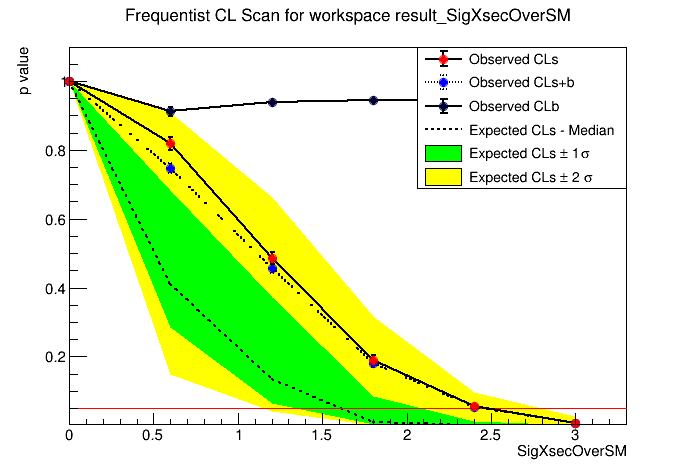

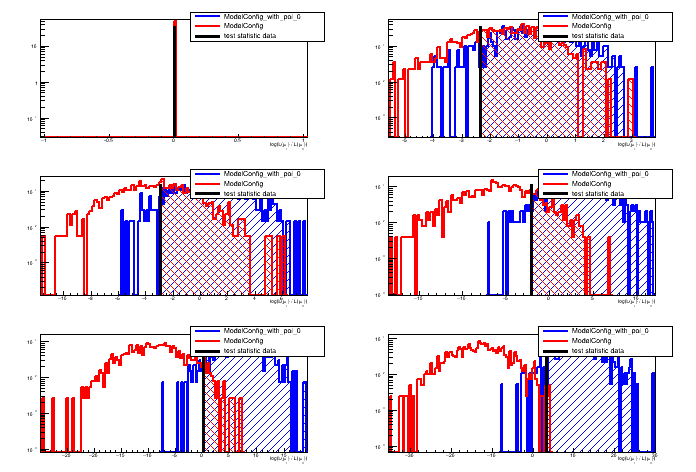

Warning in <TROOT::Append>: Replacing existing TH1: CLb_observed (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: CLs+b_observed (Potential memory leak).


In [19]:
gROOT->GetListOfCanvases()->Draw()